In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import pandas as pd
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AutoModel 
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tqdm import trange
import random

In [ ]:
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/TCC II/30K-2-epochs-neuralmind-bert-base-portuguese-cased/model",local_files_only=True)


In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'neuralmind/bert-base-portuguese-cased',
    do_lower_case = True
    )

In [ ]:
all_posts_df_pos_tests = pd.read_csv('/content/drive/MyDrive/TCC II/all_800_posts_to_analyse_pos_test.csv')
all_posts_df_pos_tests

,facebookId,pre_processed_message,message_min_processed,label
0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0
1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0
2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0
3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0
4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0
...,...,...,...,...
795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1
796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1
797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1
798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1


In [ ]:
text = all_posts_df_pos_tests.pre_processed_message.values
labels = all_posts_df_pos_tests.label.values

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16


test_idx = list(range(len(labels)))

test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        labels[test_idx])

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [ ]:
# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
new_sentence = 'bolsonaro bom'

test_ids = []
test_attention_mask = []

encoding = preprocessing(new_sentence, tokenizer)

test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

print(output.logits)

prediction = 'Direita' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Esquerda'


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

tensor([[-0.0739,  0.1594]])
Input Sentence:  bolsonaro bom
Predicted Class:  Direita


In [ ]:
print(labels.size())
print(labels)

torch.Size([800])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [ ]:
index = 0
predictions = []

for sample in text:
  test_ids = []
  test_attention_mask = []

  encoding = preprocessing(sample, tokenizer)

  test_ids.append(encoding['input_ids'])
  test_attention_mask.append(encoding['attention_mask'])
  test_ids = torch.cat(test_ids, dim = 0)
  test_attention_mask = torch.cat(test_attention_mask, dim = 0)

  with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
  index = index + 1
  prediction = np.argmax(output.logits.cpu().numpy()).flatten().item()
  print(index)
  predictions.append(prediction)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
print(predictions)

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [ ]:
test_accuracy, test_precision, test_recall, test_specificity = b_metrics(predictions, labels)

In [ ]:
print(len(predictions),len(labels))

800 800


In [ ]:
print('accuracy:',test_accuracy,'\nprecision:', test_precision, '\nrecall',test_recall, '\nspecificity', test_specificity)

accuracy: tensor(0.7425) 
precision: tensor(0.7904) 
recall tensor(0.6600) 
specificity tensor(0.8250)


In [ ]:
right_hit = b_tp(predictions,labels)
right_error = b_fp(predictions,labels)
left_hit = b_fp(predictions,labels)
left_error = b_fn(predictions,labels)

In [ ]:
print('acertos direita:',right_hit)
print('errors direita:',right_error)
print('acertos esquerda:',left_hit)
print('errors esquerta:',left_error)

acertos direita: tensor(264)
errors direita: tensor(70)
acertos esquerda: tensor(70)
errors esquerta: tensor(136)


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
confusion_matrix = metrics.confusion_matrix(labels, predictions)

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Esquerda', 'Direita'])

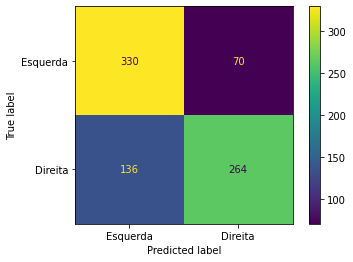

In [ ]:
cm_display.plot()
plt.show()

In [ ]:
all_posts_df_pos_tests['Prediction'] = predictions

In [ ]:
all_posts_df_pos_tests

,facebookId,pre_processed_message,message_min_processed,label,Prediction
0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,1
1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,1
2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0
3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0
4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0
...,...,...,...,...,...
795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1
796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1
797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1
798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1


In [ ]:
all_posts_df_pos_tests['hit'] = all_posts_df_pos_tests['Prediction'].eq(all_posts_df_pos_tests['label'])

In [ ]:
all_posts_df_pos_tests

,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,1,False
1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,1,False
2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0,True
3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0,True
4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0,True
...,...,...,...,...,...,...
795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1,True
796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1,True
797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1,True
798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1,True


In [ ]:
all_posts_df_pos_tests

,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,1,False
1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,1,False
2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0,True
3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0,True
4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0,True
...,...,...,...,...,...,...
795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1,True
796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1,True
797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1,True
798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1,True


In [ ]:
all_posts_df_pos_tests.to_csv('/content/drive/MyDrive/TCC II/30K-2-epochs-neuralmind-bert-base-portuguese-cased/results/800_all_posts_df_pos_tests_with_results.csv')

In [ ]:
all_posts = pd.read_csv('/content/drive/MyDrive/TCC II/30K-2-epochs-neuralmind-bert-base-portuguese-cased/results/800_all_posts_df_pos_tests_with_results.csv')

In [ ]:
all_posts

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
0,0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,1,False
1,1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,1,False
2,2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0,True
3,3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0,True
4,4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0,True
...,...,...,...,...,...,...,...
795,795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1,True
796,796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1,True
797,797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1,True
798,798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1,True


In [ ]:
labels = all_posts['label']
predictions = all_posts['Prediction']

In [ ]:
labels_right = all_posts[all_posts["label"] == 1]
labels_right 

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
400,400,890711084350263,americanas amer declara dividas r bilhoes just...,americanas ( amer3 ) declara dividas de r $ 40...,1,1,True
401,401,890711084350263,presa solta brasil queremos brasil quer,presa solta esse e brasil que queremos ? esse ...,1,1,True
402,402,890711084350263,explicando dificil entender entao desenhando p...,se explicando esta dificil entender entao dese...,1,0,False
403,403,409388089120866,mfei esthetic m,mfei esthetic m,1,0,False
404,404,409388089120866,amorrrrrrrr siga obrasilbr insta boulos ameaca...,e o amorrrrrrrr ! siga @ obrasilbr no insta bo...,1,1,True
...,...,...,...,...,...,...,...
795,795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1,True
796,796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1,True
797,797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1,True
798,798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1,True


In [ ]:
labels_left = all_posts[all_posts["label"] == 0]
labels_left

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
0,0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,1,False
1,1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,1,False
2,2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0,True
3,3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0,True
4,4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0,True
...,...,...,...,...,...,...,...
395,395,292074710916413,fernandes,por fernandes,0,0,True
396,396,292074710916413,miguel paiva,por miguel paiva,0,0,True
397,397,292074710916413,thiago,por thiago,0,0,True
398,398,292074710916413,brum,por brum,0,0,True


In [ ]:
labels_left_hit = all_posts[(all_posts['label'] == 0) & (all_posts['Prediction'] == 0 )]
labels_left_hit

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
2,2,292074710916413,ibama sob nova direcao deputado federal rodrig...,ibama sob nova direcao o deputado federal rodr...,0,0,True
3,3,292074710916413,membro republica olavista londrina professor u...,o membro da republica olavista de londrina e t...,0,0,True
4,4,292074710916413,movimentos sociais betim mg promovem ato frent...,movimentos sociais de betim ( mg ) promovem at...,0,0,True
5,5,292074710916413,invasao brasilia repressao policial peru soma ...,* invasao em brasilia * * repressao policial n...,0,0,True
6,6,292074710916413,globo demite bolsonarista cassia kiss atriz vi...,globo demite a bolsonarista cassia kiss atriz ...,0,0,True
...,...,...,...,...,...,...,...
394,394,292074710916413,parabens companheira guerreira dilmarousseff i...,parabens companheira guerreira @ dilmarousseff...,0,0,True
395,395,292074710916413,fernandes,por fernandes,0,0,True
396,396,292074710916413,miguel paiva,por miguel paiva,0,0,True
397,397,292074710916413,thiago,por thiago,0,0,True


In [ ]:
labels_left_error = all_posts[(all_posts['label'] == 0) & (all_posts['Prediction'] == 1 )]
labels_left_error

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
0,0,292074710916413,anderson torres chega brasilia exministro pres...,anderson torres chega a brasilia ex-ministro j...,0,1,False
1,1,665517103649471,presidente lula reune trabalhadores palacio pl...,presidente lula reune trabalhadores do palacio...,0,1,False
19,19,100068681299329,ahora si ofendi ana varela nda cuenta nana kar...,ahora si me ofendi @ ana varela 2nda cuenta ! ...,0,1,False
31,31,292074710916413,presidente lula fala agora governadores estado...,o presidente lula fala agora aos governadores ...,0,1,False
65,65,292074710916413,urgente agu pede prisao ex secretario seguranc...,urgente : agu pede a prisao do ex secretario d...,0,1,False
...,...,...,...,...,...,...,...
381,381,292074710916413,kleber marques,por kleber marques,0,1,False
383,383,292074710916413,aroeira one or more people bimbalham sinos dei...,por aroeira one or more people 'bimbalham sino...,0,1,False
386,386,292074710916413,,,0,1,False
392,392,292074710916413,cellus amor bandido podemos continuar encontra...,por cellus amor bandido nao podemos continuar ...,0,1,False


In [ ]:
labels_right_hit = all_posts[(all_posts['label'] == 1) & (all_posts['Prediction'] == 1 )]
labels_right_hit

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
400,400,890711084350263,americanas amer declara dividas r bilhoes just...,americanas ( amer3 ) declara dividas de r $ 40...,1,1,True
401,401,890711084350263,presa solta brasil queremos brasil quer,presa solta esse e brasil que queremos ? esse ...,1,1,True
404,404,409388089120866,amorrrrrrrr siga obrasilbr insta boulos ameaca...,e o amorrrrrrrr ! siga @ obrasilbr no insta bo...,1,1,True
405,405,890711084350263,lula deveria voltar cadeia sim n responda,lula deveria voltar para cadeia ? sim n ao ? r...,1,1,True
406,406,890711084350263,lula deveria voltar cadeia sim n responda,lula deveria voltar para cadeia ? sim n ao ? r...,1,1,True
...,...,...,...,...,...,...,...
795,795,100068234133822,ser assim apoiamos espalhem greve geral n bras...,ja que tem que ser assim apoiamos ! espalhem !...,1,1,True
796,796,890711084350263,deus misericordia nacao,- que deus tenha misericordia da nossa nacao,1,1,True
797,797,890711084350263,rdem progresso progresso bandeira nunca vermel...,rdem e progresso progresso nossa bandeira nunc...,1,1,True
798,798,409388089120866,siga forapt instagram,siga @ forapt.13 no instagram,1,1,True


In [ ]:
labels_right_error = all_posts[(all_posts['label'] == 1) & (all_posts['Prediction'] == 0 )]
labels_right_error

,Unnamed: 0,facebookId,pre_processed_message,message_min_processed,label,Prediction,hit
402,402,890711084350263,explicando dificil entender entao desenhando p...,se explicando esta dificil entender entao dese...,1,0,False
403,403,409388089120866,mfei esthetic m,mfei esthetic m,1,0,False
408,408,409388089120866,ainda liga tv nisso one or more people and peo...,voce ainda liga sua tv nisso ? one or more peo...,1,0,False
414,414,890711084350263,correcao falso governo luiz inacio lula silva ...,correcao : e falso que o governo de luiz inaci...,1,0,False
417,417,890711084350263,ex atreta acha evolui filha ana moser nova min...,a ex `` atreta '' acha que estamos em 1950 evo...,1,0,False
...,...,...,...,...,...,...,...
771,771,100068234133822,golpe dado stf juristas x stf finalmente grand...,o golpe ja foi dado mas foi pelo stf . jurista...,1,0,False
772,772,890711084350263,lembrancas picanha,lembrancas da picanha de 2002 ha 2016 !,1,0,False
773,773,890711084350263,carioca marvio lucio cariocadelegado atencao p...,carioca marvio lucio @ cariocadelegado atencao...,1,0,False
776,776,409388089120866,faz socorro alguem invadindo casa arma senhora...,faz socorro ! tem alguem invadindo a minha cas...,1,0,False


In [ ]:
print('Acertos esquerda:',len(labels_left_hit))
print('Erros esquerda:',len(labels_left_error))
print('Acertos direita:',len(labels_right_hit))
print('Errors direita:',len(labels_right_error))


Acertos esquerda: 330
Erros esquerda: 70
Acertos direita: 264
Errors direita: 136
